<a href="https://colab.research.google.com/github/JebaMercy14/Time-Series-Algorithms/blob/main/Time_Series_Analysis_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


# IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore")

# LOAD DATASET

In [3]:
#Read the dataset
df = pd.read_csv('/content/monthly-beer-production-in-austr.csv')
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [5]:
df.Month = pd.to_datetime(df.Month)
df.set_index('Month', inplace=True)
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [6]:
df['Log_Production']=np.log(df['Monthly beer production'])

# Basic Data Plot

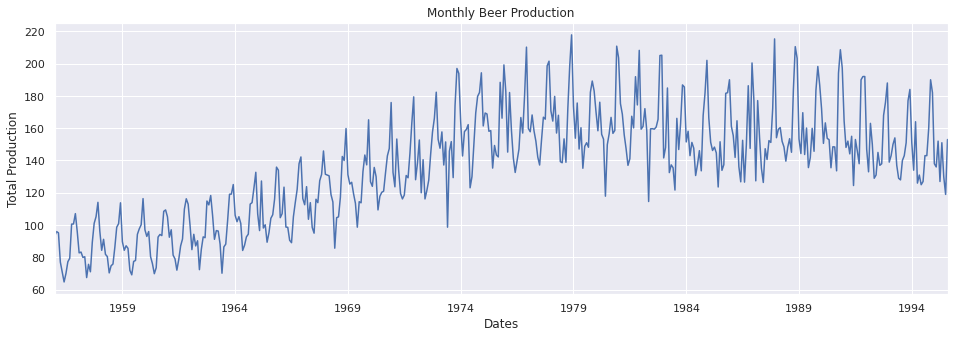

In [7]:
df.index.freq = 'MS'
ax = df['Monthly beer production'].plot(figsize = (16,5), title = "Monthly Beer Production")
ax.set(xlabel='Dates', ylabel='Total Production');

# Seasonal Decompose Plots

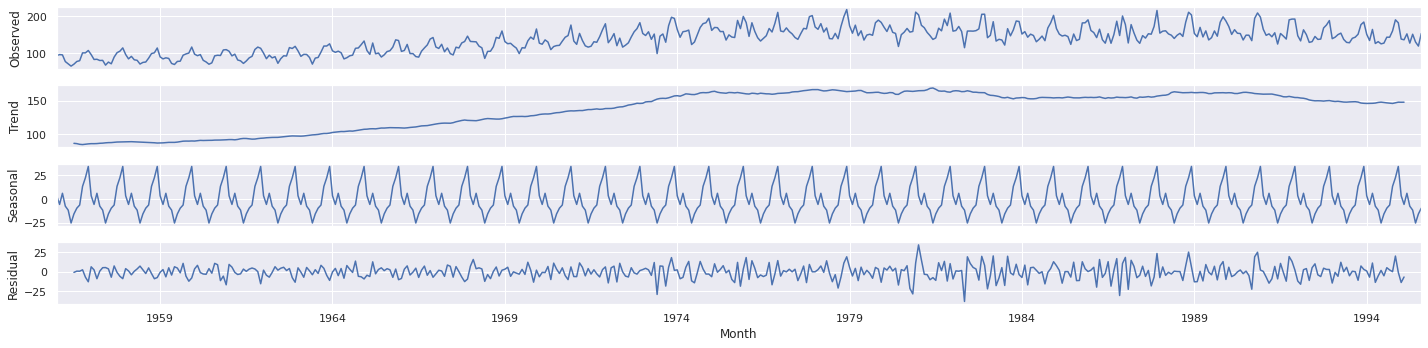

In [8]:
res = seasonal_decompose(df["Monthly beer production"], model = "add")

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(20,5))

plotseasonal(res, axes)

plt.tight_layout()
plt.show()

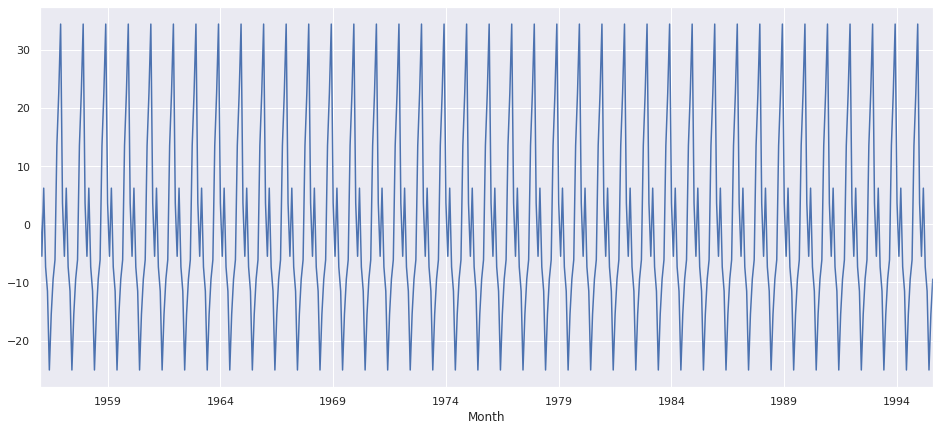

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
res.seasonal.plot();

# Stationarity analysis

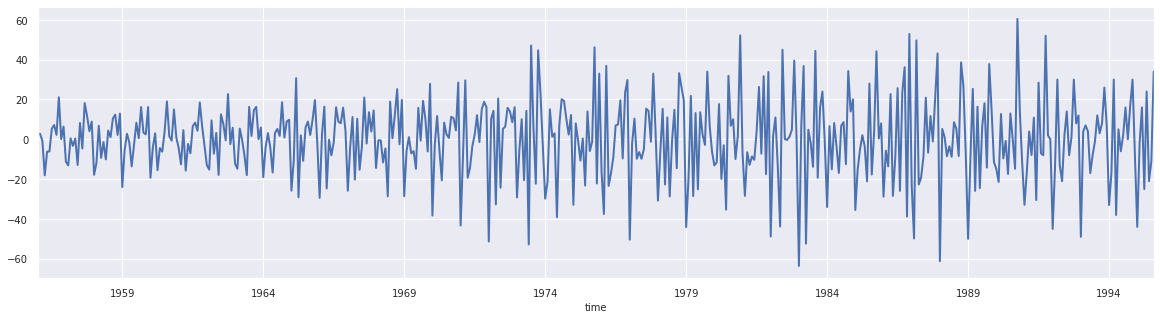

In [10]:
beer=df['Monthly beer production']
Log_beer=df['Log_Production']

beer.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)
plt.xlabel('time', fontsize=10);

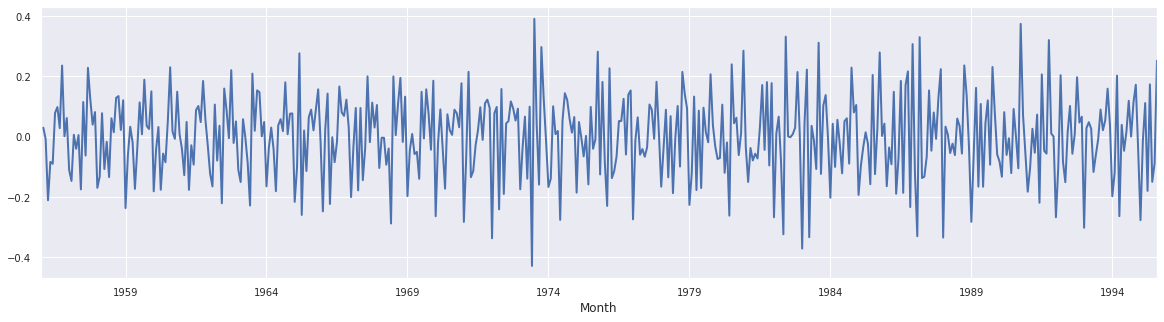

In [11]:
Log_beer.diff().plot(figsize=(20,5), linewidth=2, fontsize=10)

# Dickey-Fuller test

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
result = adfuller(df['Log_Production'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.800769
p-value: 0.058164
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


# Dickey-Fuller test - first difference

In [ ]:
result = adfuller(df['Log_Production'].diff().iloc[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.869646
p-value: 0.000040
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


# Autocorrelation of the series under analysis

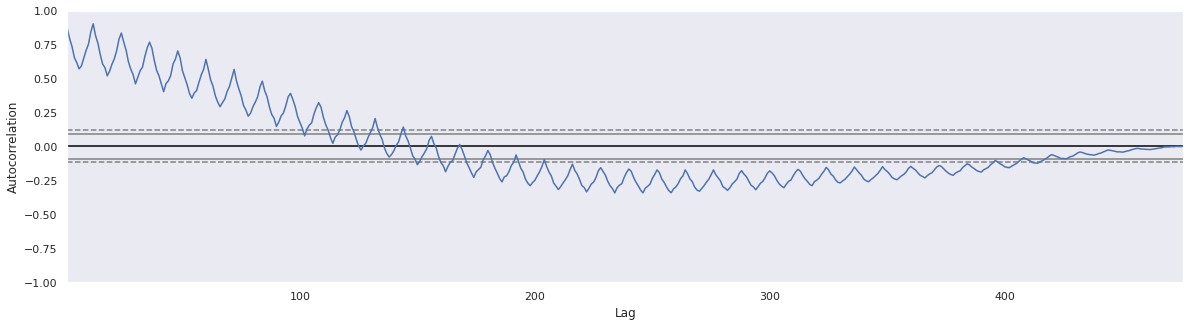

In [14]:
plt.figure(figsize=(20,5))
pd.plotting.autocorrelation_plot(df['Log_Production']);

# Autocorrelation of the first difference of the series under analysis

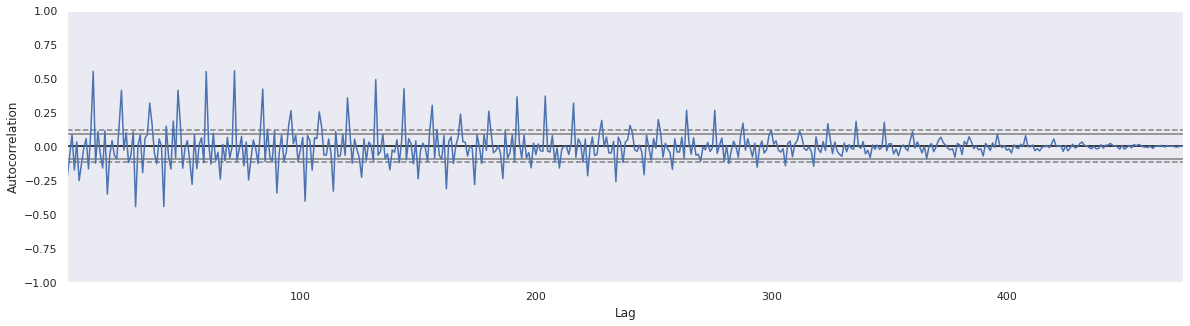

In [15]:
plt.figure(figsize=(20,5))
pd.plotting.autocorrelation_plot(df['Log_Production'].diff().iloc[1:]);

# simple and partial autocorrelation beer production series

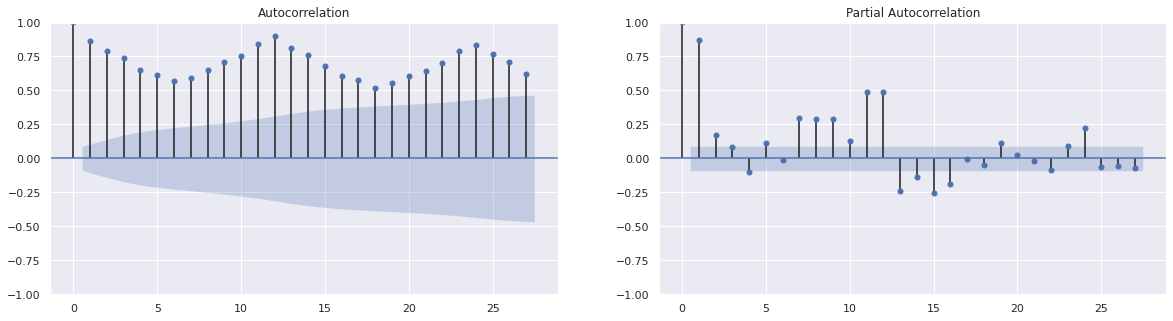

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(df['Log_Production'], ax=ax[0])
plot_pacf(df['Log_Production'], ax=ax[1])
plt.show()

# Simple and partial first difference autocorrelation of beer production series

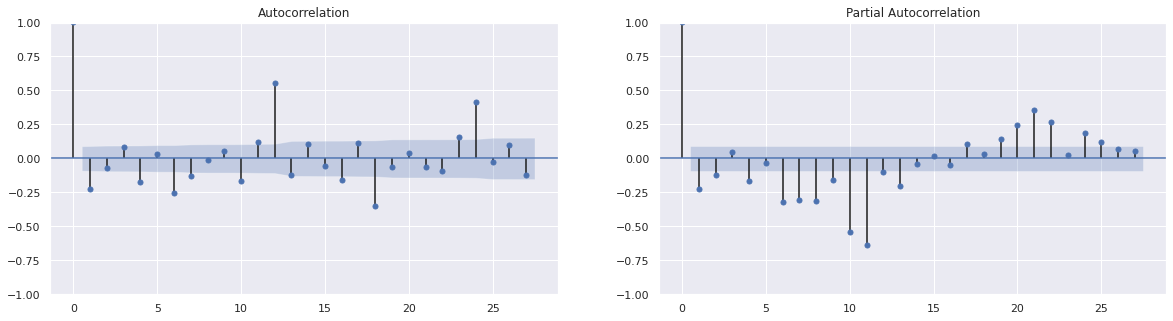

In [17]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_acf(df['Log_Production'].diff().iloc[1:], ax=ax[0])
plot_pacf(df['Log_Production'].diff().iloc[1:], ax=ax[1])
plt.show()

# ARIMA Forecast

## Train-Test split


In [18]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]
arima_model = SARIMAX(train_data['Monthly beer production'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                    Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -1708.019
Date:                                    Sat, 11 Feb 2023   AIC                           3438.038
Time:                                            09:25:58   BIC                           3483.553
Sample:                                        01-01-1956   HQIC                          3455.956
                                             - 08-01-1994                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1236      0.042     -2.976      0.003      -0.205      -0.042
ar.L2         -0.1719      0.045     -3.801      0.000      -0.261      -0.083
ma.L1         -0.8453      0.028    -30.721      0.000      -0.899      -0.791
ar.S.L12       1.7573      0.094     18.648      0.000       1.573       1.942
ar.S.L24      -1.6135      0.170     -9.464      0.000      -1.948      -1.279
ar.S.L36       0.7925      0.126      6.286      0.000       0.545       1.040
ar.S.L48       0.0624      0.044      1.420      0.156      -0.024       0.148
ma.S.L12      -1.5587      0.112    -13.930      0.000      -1.778      -1.339
ma.S.L24       1.3945      0.180      7.742      0.000       1.041       1.747
ma.S.L36      -0.6633      0.105     -6.305      0.000      -0.869      -0.457
sigma2        84.1171      4.890     17.203      0.000      74.533      93.701
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                41.16
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.06   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction

In [19]:
#Prediction
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

1994-09-01    134.083049
1994-10-01    157.771520
1994-11-01    181.706515
1994-12-01    183.619047
1995-01-01    144.967230
1995-02-01    136.944261
1995-03-01    151.255062
1995-04-01    133.274236
1995-05-01    137.902957
1995-06-01    120.603813
1995-07-01    128.476267
1995-08-01    138.860551
Freq: MS, Name: ARIMA Predictions, dtype: float64

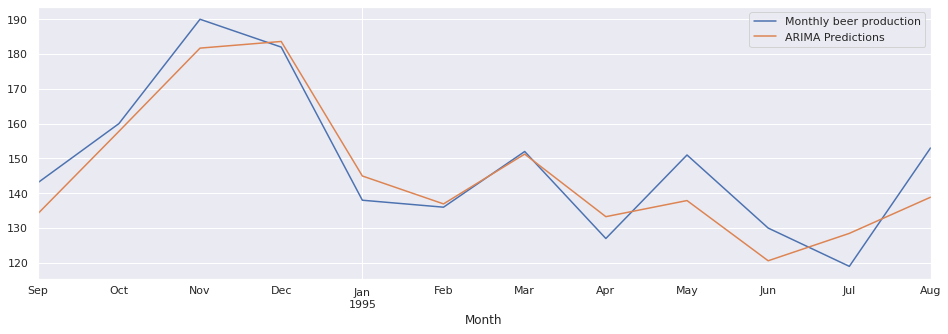

In [20]:
test_data['Monthly beer production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

## Model Evaluation

In [21]:
arima_rmse_error = rmse(test_data['Monthly beer production'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Monthly beer production'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 66.23173083709986
RMSE Error: 8.138287954914096
Mean: 136.3953781512605


In [22]:
test_data['ARIMA_Predictions'] = arima_pred

In [33]:
test_data['ARIMA_Predictions']

Month
1994-09-01    134.083049
1994-10-01    157.771520
1994-11-01    181.706515
1994-12-01    183.619047
1995-01-01    144.967230
1995-02-01    136.944261
1995-03-01    151.255062
1995-04-01    133.274236
1995-05-01    137.902957
1995-06-01    120.603813
1995-07-01    128.476267
1995-08-01    138.860551
Freq: MS, Name: ARIMA_Predictions, dtype: float64